# LLM Factor Analysis - Personality Items

Extracts embeddings from NEO personality items using DistilBERT and compares predicted similarities with observed correlations.

## Setup and Data Validation

In [1]:
import os
import sys

print("Starting LLM Factor Analysis...")

# Check for required data files
required_files = ['NEO_items.csv', 'item_corrs.csv']
missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print(f"Error: Missing required data files: {', '.join(missing_files)}")
    print("Please ensure these files are in the current working directory.")
else:
    print("Data files found. Loading dependencies (this may take a moment)...")

Starting LLM Factor Analysis...
Data files found. Loading dependencies (this may take a moment)...


## Import Dependencies

In [2]:
import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

from datasets import Dataset
print("  - datasets loaded")

from transformers import AutoTokenizer
print("  - transformers loaded")

  - pandas and numpy loaded


/Users/devon7y/VS Code/LLM Factor Analysis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  - datasets loaded
  - transformers loaded


## Load and Process Data

In [3]:
print("Loading NEO personality items...")
neo_items = pd.read_csv('NEO_items.csv', usecols=['item', 'factor'])
print(f"Loaded {len(neo_items)} items")

# Preview the data
neo_items.head()

Loading NEO personality items...
Loaded 300 items


,item,factor
0,Go straight for the goal.,Conscientiousness
1,Plunge into tasks with all my heart.,Conscientiousness
2,Demand quality.,Conscientiousness
3,Set high standards for myself and others.,Conscientiousness
4,Turn plans into actions.,Conscientiousness


In [4]:
# Converting into a HuggingFace dataset
dat = Dataset.from_pandas(neo_items)
dat

Dataset({
    features: ['item', 'factor'],
    num_rows: 300
})

## Tokenization

In [5]:
# Loading the tokenizer
print("Loading tokenizer...")
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
print(f'Vocabulary size: {tokenizer.vocab_size}, max context length: {tokenizer.model_max_length}')

Loading tokenizer...
Vocabulary size: 30522, max context length: 512


In [6]:
# Tokenizing the text
print("Tokenizing items...")
batch_tokenizer = lambda x: tokenizer(x['item'], padding=True, truncation=True)
dat = dat.map(batch_tokenizer, batched=True, batch_size=None)
print(f"Sample tokenization: {[tokenizer.decode(id) for id in dat['input_ids'][0]]}")

Tokenizing items...


Map: 100%|██████████| 300/300 [00:00<00:00, 15780.52 examples/s]

Sample tokenization: ['[CLS]', 'go', 'straight', 'for', 'the', 'goal', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [7]:
# Setting the format of the dataset to torch tensors for passing to the model
dat.set_format('torch', columns=['input_ids', 'attention_mask'])
print(f"Dataset shape: {np.array(dat['input_ids']).shape}")

Dataset shape: (300, 16)


## Feature Extraction

In [8]:
print("Loading PyTorch (this may take 10-30 seconds on first run)...")
import torch
print("  - torch loaded")

from transformers import AutoModel

Loading PyTorch (this may take 10-30 seconds on first run)...
  - torch loaded


In [9]:
# Loading the model and moving it to the GPU if available
print("Detecting available device...")
if torch.cuda.is_available():  # for nvidia GPUs
    device = torch.device('cuda')
    print("Using CUDA GPU")
elif torch.backends.mps.is_available(): # for Apple Metal Performance Shaders (MPS) GPUs
    device = torch.device('mps')
    print("Using Apple MPS GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Detecting available device...
Using Apple MPS GPU


In [10]:
# Loading the model
print("Loading DistilBERT model...")
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)
print(f'Model inputs: {tokenizer.model_input_names}')

Loading DistilBERT model...
Model inputs: ['input_ids', 'attention_mask']


In [11]:
def extract_features(batch):
    """Extract features from a batch of items"""
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [12]:
print("Extracting features from items...")
dat = dat.map(extract_features, batched=True, batch_size=8)
print(f"Feature extraction complete. Shape: {np.array(dat['hidden_state']).shape}")

Extracting features from items...


Map: 100%|██████████| 300/300 [00:00<00:00, 502.23 examples/s]

Feature extraction complete. Shape: (300, 768)


## Inspect Results

In [13]:
# View the dataset structure
dat

Dataset({
    features: ['item', 'factor', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 300
})

In [14]:
# Column names
dat.column_names

['item', 'factor', 'input_ids', 'attention_mask', 'hidden_state']

In [15]:
# Check embedding dimensions (fast)
print(f"Hidden state shape: {dat[0]['hidden_state'].shape}")
print(f"Embedding size: {len(dat[0]['hidden_state'])} dimensions")

Hidden state shape: torch.Size([768])
Embedding size: 768 dimensions


In [16]:
# View a single embedding vector (first 10 values only)
print("First 10 values of first embedding:")
print(dat[0]['hidden_state'][:10])

# Summary statistics
print(f"\nEmbedding stats:")
print(f"  Min: {dat[0]['hidden_state'].min():.4f}")
print(f"  Max: {dat[0]['hidden_state'].max():.4f}")
print(f"  Mean: {dat[0]['hidden_state'].mean():.4f}")

First 10 values of first embedding:
tensor([-0.1016, -0.2323,  0.0532, -0.2092, -0.1470, -0.4463,  0.1998,  0.2810,
         0.1252, -0.6137])

Embedding stats:
  Min: -7.5746
  Max: 3.6303
  Mean: -0.0092


## T-SNE Visualization

Visualize the 768-dimensional embeddings in 2D space using T-SNE, color-coded by personality construct.

In [17]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [18]:
# Prepare data for T-SNE
print("Preparing embeddings matrix...")

# Extract all embeddings into a numpy array (300 x 768)
embeddings = np.array([dat[i]['hidden_state'] for i in range(len(dat))])
print(f"Embeddings shape: {embeddings.shape}")

# Reset format to access text columns
dat.reset_format()

# Extract factor labels from the dataset
factors_list = [dat[i]['factor'] for i in range(len(dat))]
print(f"Number of items: {len(factors_list)}")

# Get unique factors for legend
unique_factors = sorted(set(factors_list))
print(f"Personality factors: {unique_factors}")

Preparing embeddings matrix...
Embeddings shape: (300, 768)
Number of items: 300
Personality factors: ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']


In [19]:
# Run T-SNE dimensionality reduction
print("Running T-SNE (this may take 10-30 seconds)...")

tsne = TSNE(
    n_components=2,      # Reduce to 2D
    perplexity=30,       # Balance local vs global structure
    max_iter=1000,       # Number of iterations (was n_iter, but sklearn uses max_iter)
    random_state=42,     # For reproducibility
    verbose=1            # Show progress
)

# Transform 768D embeddings to 2D
embeddings_2d = tsne.fit_transform(embeddings)
print(f"T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

Running T-SNE (this may take 10-30 seconds)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 1.245983


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.980721
[t-SNE] KL divergence after 1000 iterations: 0.818220
T-SNE complete! 2D embeddings shape: (300, 2)


Creating visualization...


/var/folders/tw/9fmk8_cs08v70918my8dtdmh0000gn/T/ipykernel_72910/2119241136.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_factors))


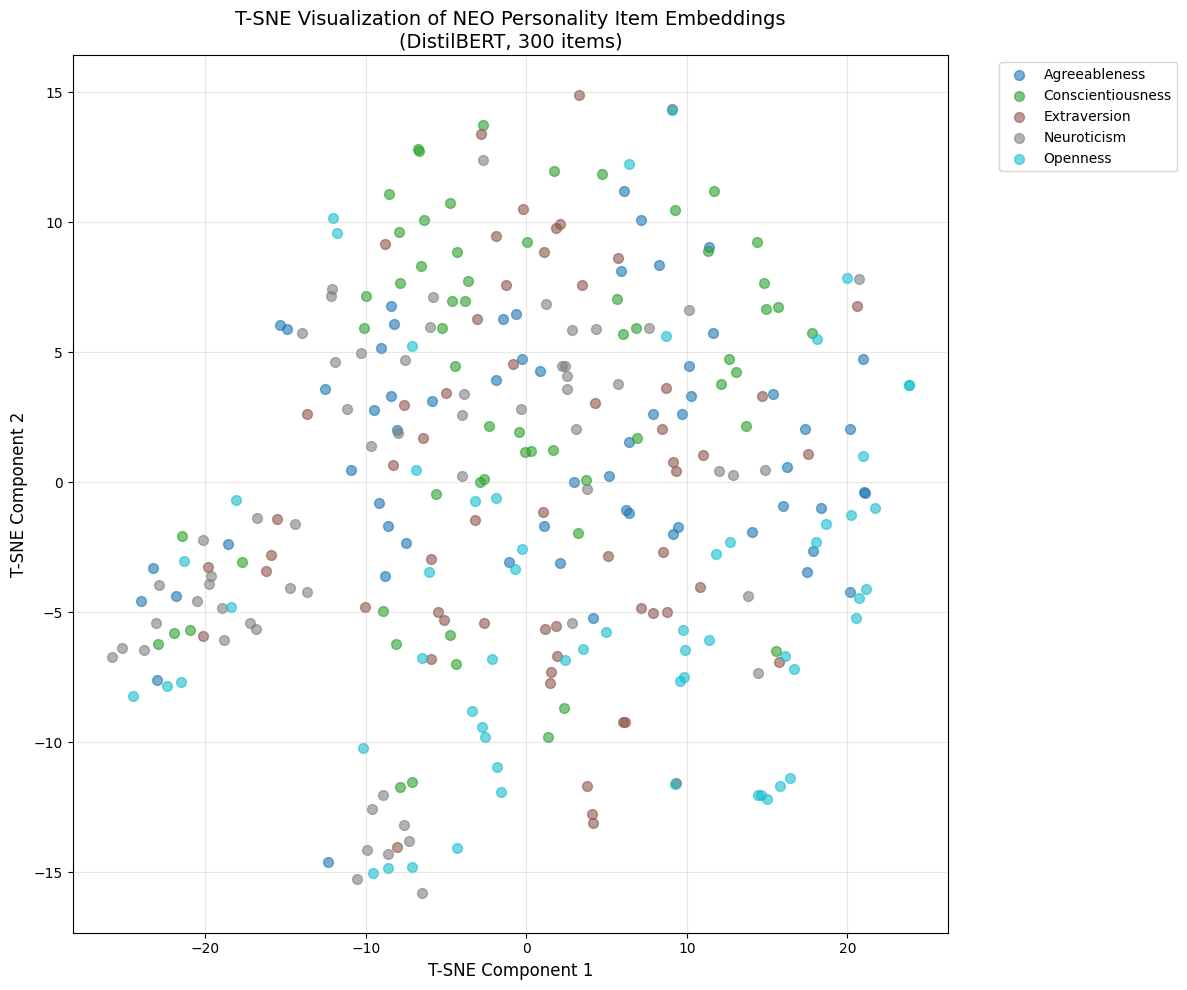

Visualization complete!


In [20]:
# Create the T-SNE scatter plot
print("Creating visualization...")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors(i) for i, factor in enumerate(unique_factors)}

# Create figure
plt.figure(figsize=(12, 10))

# Plot each factor with a different color
for factor in unique_factors:
    # Get indices for this factor
    indices = [i for i, f in enumerate(factors_list) if f == factor]
    
    # Plot points for this factor
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        c=[factor_to_color[factor]],
        label=factor,
        alpha=0.6,
        s=50
    )

plt.xlabel('T-SNE Component 1', fontsize=12)
plt.ylabel('T-SNE Component 2', fontsize=12)
plt.title('T-SNE Visualization of NEO Personality Item Embeddings\n(DistilBERT, 300 items)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualization complete!")

In [21]:
# Optional: Explore nearest neighbors in 2D space
print("Finding nearest neighbors in embedding space...")

# Pick a random item to analyze
sample_idx = 0
sample_item = dat[sample_idx]['item']
sample_factor = factors_list[sample_idx]

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {sample_factor}")
print(f"  Text: {sample_item}")

# Calculate distances to all other items in 2D space
from scipy.spatial.distance import cdist
distances = cdist([embeddings_2d[sample_idx]], embeddings_2d)[0]

# Find 5 nearest neighbors (excluding itself)
nearest_indices = np.argsort(distances)[1:6]

print(f"\n5 Nearest neighbors in 2D space:")
for rank, idx in enumerate(nearest_indices, 1):
    print(f"  {rank}. [{factors_list[idx]}] {dat[idx]['item']} (distance: {distances[idx]:.3f})")

Finding nearest neighbors in embedding space...

Sample item #0:
  Factor: Conscientiousness
  Text: Go straight for the goal.

5 Nearest neighbors in 2D space:
  1. [Extraversion] React slowly. (distance: 2.069)
  2. [Extraversion] React quickly. (distance: 2.200)
  3. [Extraversion] Act wild and crazy. (distance: 2.415)
  4. [Conscientiousness] Postpone decisions. (distance: 2.990)
  5. [Extraversion] Take charge. (distance: 3.183)
